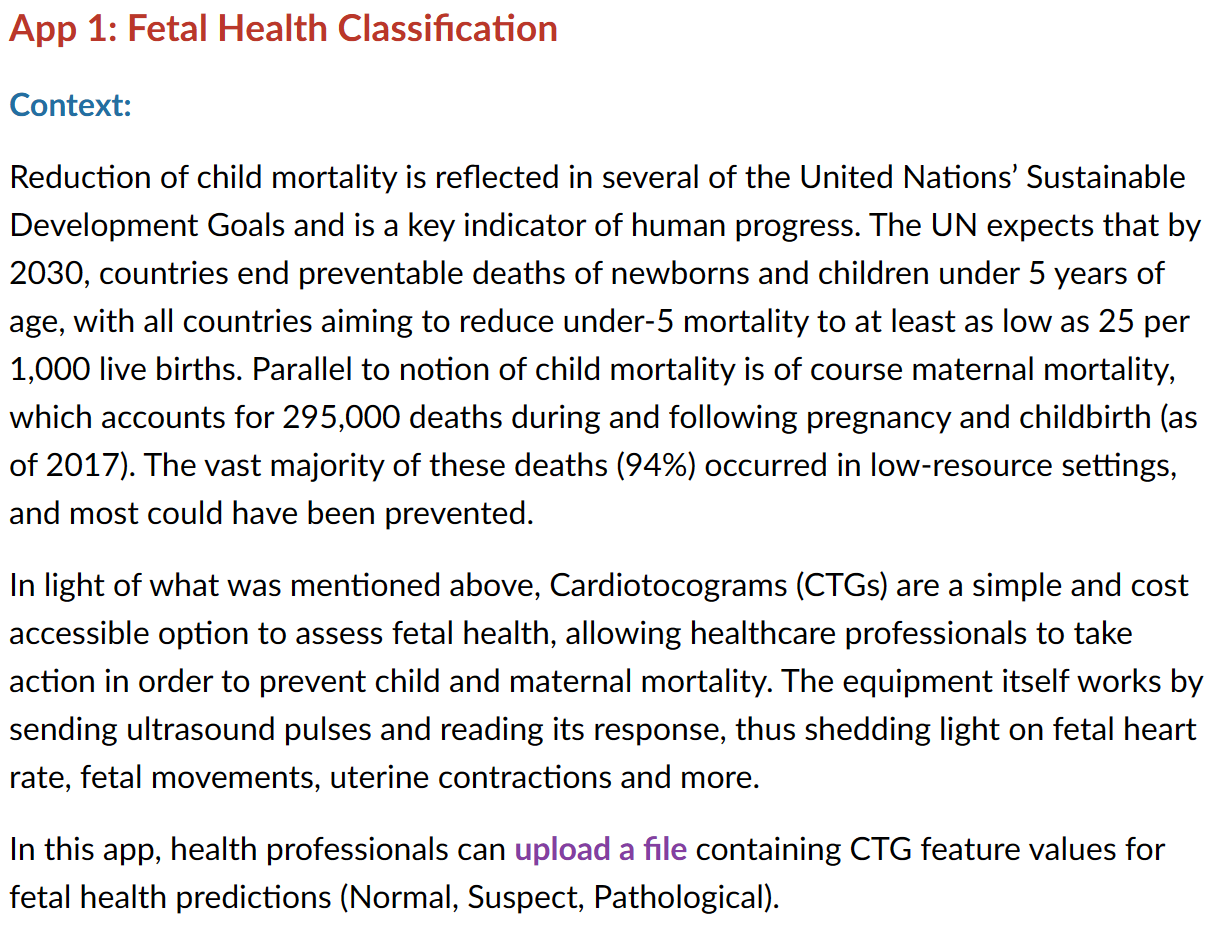

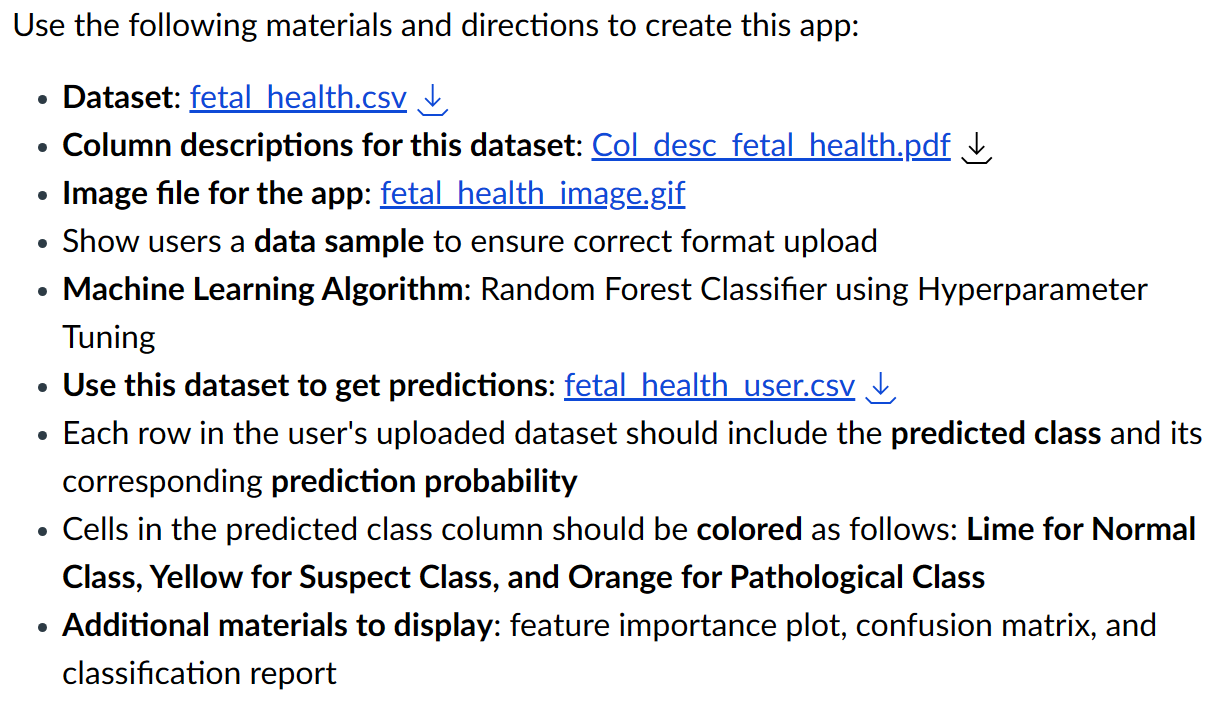

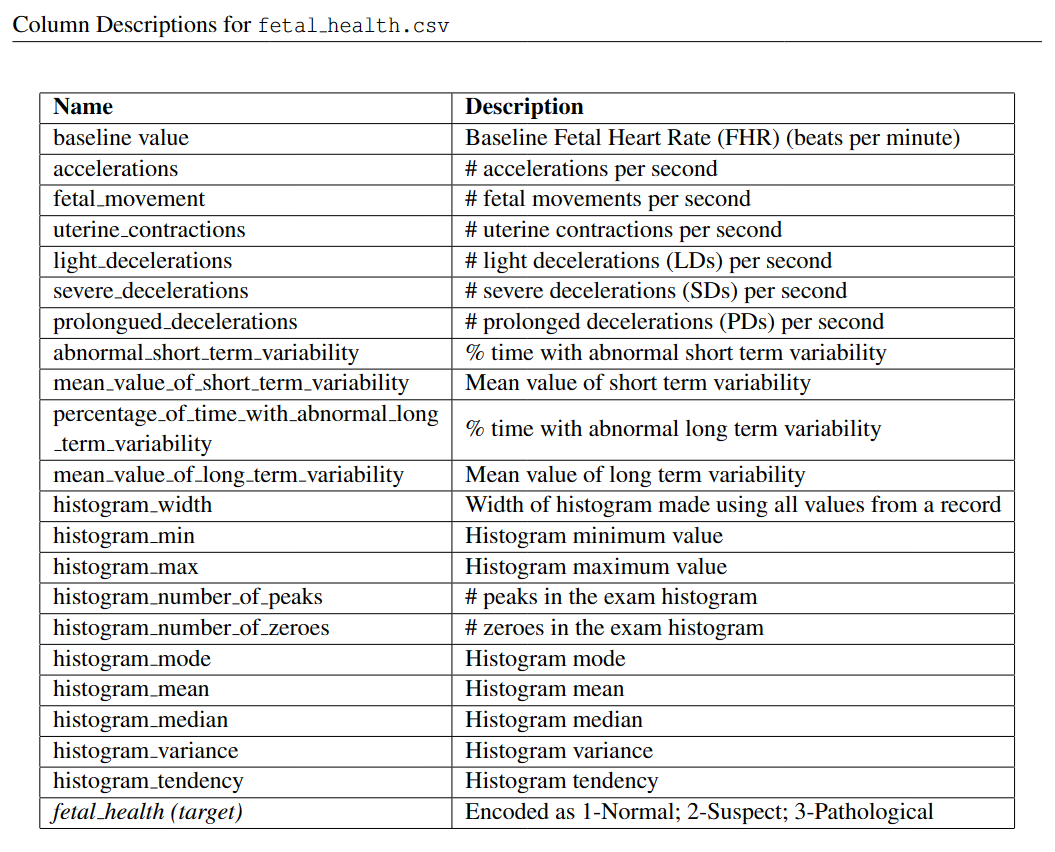

In [1]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import seaborn as sns                # Seaborn

# Package to implement Random Forest Classifier
import sklearn
from sklearn.ensemble import RandomForestClassifier

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Packages for generating confusion matrix, R2, RMSE, classification report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score, mean_squared_error, classification_report

# Import packages to implement Stratified K-fold CV, Grid Search, Randomized Search
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV

# Package to record time
import time

# Package for Data pretty printer
from pprint import pprint

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Module to save and load Python objects to and from files
import pickle 

%matplotlib inline

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

In [2]:
# Import Data
fetal_df = pd.read_csv('fetal_health.csv')
# Replace all 1's in fetal_health with "Normal"
fetal_df['fetal_health'].replace(1, "Normal", inplace=True)
# Replace all 2's in fetal_health with "Suspect"
fetal_df['fetal_health'].replace(2, "Suspect", inplace=True)
# Replace all 3's in fetal_health with "Pathological"
fetal_df['fetal_health'].replace(3, "Pathological", inplace=True)
fetal_df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,Suspect
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,Normal
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,Normal
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,Normal
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,Normal


In [3]:
# Summary of the data
fetal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [4]:
# Distribution of fetal_health column
fetal_df['fetal_health'].value_counts(normalize = True)

fetal_health
Normal          0.778457
Suspect         0.138758
Pathological    0.082785
Name: proportion, dtype: float64

This is an example of Imbalanced Dataset where the distribution of instances across the classes is not equal.

In [5]:
# Set Up

# Selecting data correponding to Input Features and Output 
features = fetal_df.drop(columns = ['fetal_health'])
output = fetal_df['fetal_health']

# No categorical variables so one-hot-encoding / dummies / factorizing is not necessary

# Data Partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(features, output, test_size = 0.2, random_state = 1)

# Define the model (Random Forest Classifier)
classifier = RandomForestClassifier(random_state = 42)

# Creating folds (using StratifiedKFold because dataset is imbalanced)
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

In [6]:
# Hyperparameter Tuning

# Starting with randomized cross validation (initial guess for parameters)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(random_grid)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'min_samples_leaf': [5, 10, 20],
 'min_samples_split': [5, 10, 20],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [7]:
# Call RandomizedSearchCV()
model_cv = RandomizedSearchCV(estimator = classifier, 
                              param_distributions = random_grid,
                              n_iter = 100,
                              scoring = 'f1_weighted',
                              cv = folds, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

In [8]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Training time: 39.91476583480835s


In [9]:
print('Initial score: ', model_cv.best_score_)
print('Initial parameters: ', model_cv.best_params_)

Initial score:  0.9252114376272251
Initial parameters:  {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 14}


In [10]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [13, 14, 15, 16],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
    'n_estimators': [100, 150, 200]
}

pprint(param_grid)

{'max_depth': [13, 14, 15, 16],
 'min_samples_leaf': [2, 3, 4, 5, 6],
 'min_samples_split': [2, 3, 4, 5, 6],
 'n_estimators': [100, 150, 200]}


In [11]:
# Call GridSearchCV()
model_cv = GridSearchCV(estimator = classifier, 
                        param_grid = param_grid, 
                        scoring= 'f1_weighted', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [12]:
# Fit the model
start = time.time()            # Start Time
model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Training time: 74.98552536964417s


In [13]:
print('Improved score: ', model_cv.best_score_)
print('Improved parameters: ', model_cv.best_params_)

Improved score:  0.9384855884267157
Improved parameters:  {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


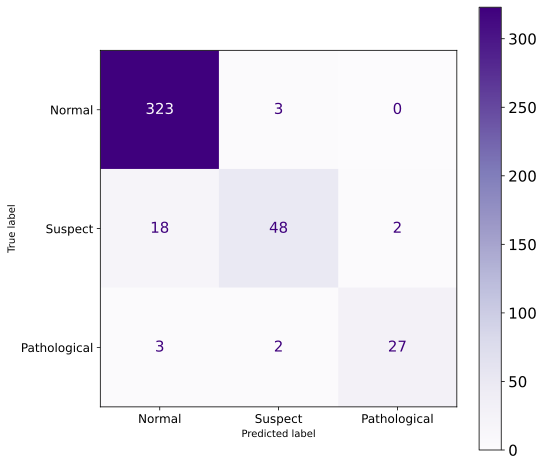

In [14]:
# Confusion Matrix

# Predictions on test set
y_pred = model_cv.predict(test_X)

# Create list of prediction order for labeling (by default it orders alphabetically)
prediction_order = ['Normal', 'Suspect', 'Pathological']

# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred, labels = prediction_order)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = prediction_order)

# Specify figure size and font size
fig, ax = plt.subplots(figsize = (8, 8))
plt.rcParams.update({'font.size': 15})
plt.yticks(fontsize = 12) # fontsize of yticks
plt.xticks(fontsize = 12) # fontsize of xticks

# Display Confusion Matrix
disp.plot(cmap = 'Purples', ax = ax);

# Saving Confusion Matrix
fig.savefig("confusion_matrix.svg", bbox_inches='tight')

In [15]:
# Generate classification report with specified labels order
report = classification_report(test_y, y_pred, labels=prediction_order, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report)

# Save the classification report to a CSV file
report_df.to_csv('classification_report.csv')

report_df

,Normal,Suspect,Pathological,accuracy,macro avg,weighted avg
precision,0.938953,0.905660,0.931034,0.934272,0.925216,0.933044
recall,0.990798,0.705882,0.843750,0.934272,0.846810,0.934272
f1-score,0.964179,0.793388,0.885246,0.934272,0.880938,0.930987
support,326.000000,68.000000,32.000000,0.934272,426.000000,426.000000


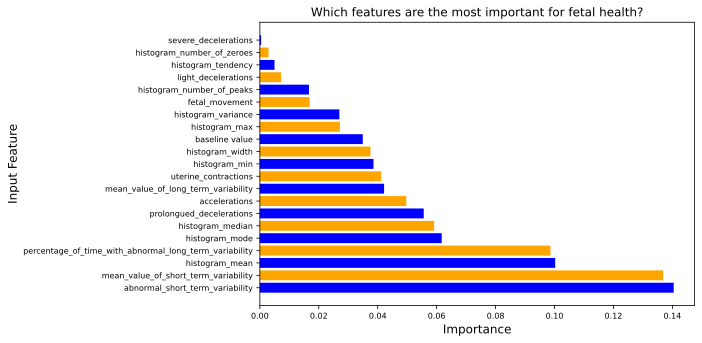

In [16]:
# Feature Importance

# Storing importance values from the trained model
importance = model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
fig1 = plt.figure(figsize=(10, 5))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['blue', 'orange'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for fetal health?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

# Saving Feature Importance Plot
fig1.savefig("feature_importance.svg", bbox_inches='tight')

In [17]:
# Save Random Forest model as pickle file

# Creating the file where we want to write the model
rf_pickle = open('rf_fetal.pickle', 'wb') 

# Write RF model to the file
pickle.dump(model_cv, rf_pickle) 

# Close the file
rf_pickle.close()